In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df_ab_test = pd.read_csv('ab_test_click_data.csv')

print(df_ab_test.head())
print(df_ab_test.describe())
print(df_ab_test.groupby("group").sum("click"))

   user_id  click group            timestamp
0        1      1   exp  2024-01-01 00:00:00
1        2      0   exp  2024-01-01 00:01:00
2        3      1   exp  2024-01-01 00:02:00
3        4      0   exp  2024-01-01 00:03:00
4        5      1   exp  2024-01-01 00:04:00
            user_id         click
count  20000.000000  20000.000000
mean   10000.500000      0.405250
std     5773.647028      0.490953
min        1.000000      0.000000
25%     5000.750000      0.000000
50%    10000.500000      0.000000
75%    15000.250000      1.000000
max    20000.000000      1.000000
         user_id  click
group                  
con    150005000   1989
exp     50005000   6116


A bar chart to show the total clicks vs no-clicks in each group to visualize the user engagement

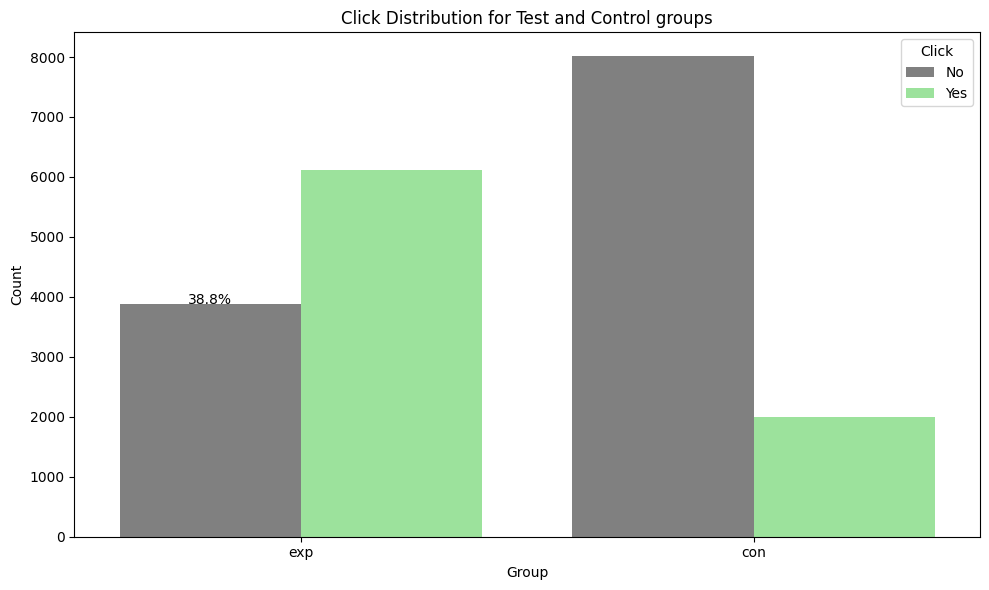

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [4]:
palette = {0: 'grey', 1: 'lightgreen'}

plt.figure(figsize=(10,6))
ax = sns.countplot(x='group', hue='click', data=df_ab_test, palette=palette)
plt.title('Click Distribution for Test and Control groups')
plt.xlabel('Group')
plt.ylabel('Count')
plt.legend(title='Click', labels = ['No', 'Yes'])

group_counts = df_ab_test.groupby(['group']).size()
group_click_counts = df_ab_test.groupby(['group', 'click']).size().reset_index(name = 'count')

for p in ax.patches:
  height = p.get_height()
  group = 'exp' if p.get_x() <0.5 else 'con'
  click = 1 if p.get_x() % 1 >0.5 else 0
  total = group_counts.loc[group]
  percentage = 100* height/total
  ax.text(p.get_x() + p.get_width()/2., height + 5, f'{percentage:.1f}%', ha="center", color = 'black', fontsize=10)

  plt.tight_layout()
  plt.show()


Defining Parameters for Analysis of the test results

In [5]:
alpha = 0.05
#significance level OR the probability of Type I error
#intuition - we are okay to make an error of 5%

delta = 0.1
#minimum detectable effect
#intuition - how much increase in CTR is good for business

Calculating the total number of clicks for both the groups

In [46]:
N_con = df_ab_test[df_ab_test["group"] == "con"].count().iloc[0]
N_exp = df_ab_test[df_ab_test["group"] == "exp"].count().iloc[0]

X_con = df_ab_test.groupby("group")["click"].sum().loc["con"]
X_exp = df_ab_test.groupby("group")["click"].sum().loc["exp"]

print("number of clicks in control group: ",X_con)
print("number of clicks in test group: ",X_exp)

number of clicks in control group:  1989
number of clicks in test group:  6116


Calculating Pooled estimates for the clicks in each of the groups

In [47]:
p_con_hat = X_con/N_con
p_exp_hat = X_exp/N_exp

print("click probability in the control group: ",p_con_hat)
print("click probability in the test group: ",p_exp_hat)

p_pooled_hat = (X_con+X_exp)/(N_con+N_exp)
print("pooled click probability: ",p_pooled_hat)

click probability in the control group:  0.1989
click probability in the test group:  0.6116
pooled click probability:  0.40525


Calculating Pooled variance

In [48]:
pooled_variance = p_pooled_hat * (1- p_pooled_hat)*(1/N_con + 1/N_exp)

print("pooled estimate is: ", p_pooled_hat)
print("pooled variance is: ", pooled_variance)

pooled estimate is:  0.40525
pooled variance is:  4.82044875e-05


Calculating standard error and test statistics

In [49]:
se = np.sqrt(pooled_variance)
print("Standard error: ", se)

test_stat = (p_con_hat - p_exp_hat)/se
print("test statistics for 2-sample Z test is: ", test_stat)

z_crit = norm.ppf(1-alpha/2)
print("Z-critical value from Standard normal distribution: ", z_crit)

Standard error:  0.006942945160376826
test statistics for 2-sample Z test is:  -59.44163326469381
Z-critical value from Standard normal distribution:  1.959963984540054


Calculating p_value for a Z-test

In [50]:
p_value = 2 * norm.sf(abs(test_stat))

def is_statistically_significant(p_value, alpha):
  print(f"p-value of the 2-sample z test: {(p_value)}")

  if p_value <= alpha:
    print("there is statistical significance ie. the observed difference between the 2 groups are unlikely to occur by chance")
  else:
    print("there is not statistical significance ie. the observed difference between the 2 grouos could have occured just by chance")

is_statistically_significant(p_value, alpha)

p-value of the 2-sample z test: 0.0
there is statistical significance ie. the observed difference between the 2 groups are unlikely to occur by chance


Calculating the confidence interval of this test

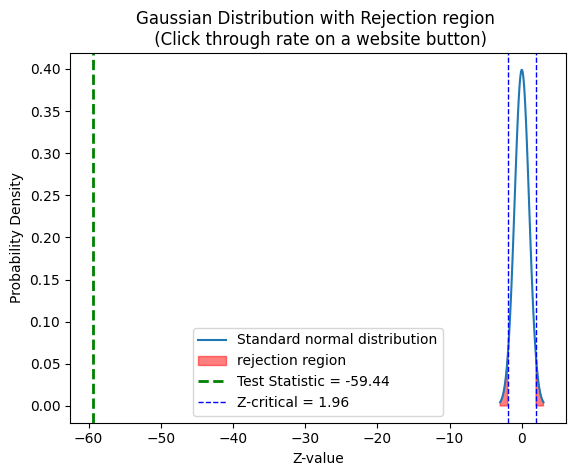

In [52]:
mu = 0 #mean
sigma = 1 #standard deviation

x = np.linspace(mu - 3*sigma, mu+3*sigma, 100)
y = norm.pdf(x,mu,sigma)

plt.plot(x,y, label = 'Standard normal distribution')
plt.fill_between(x,y, where = (x> z_crit) | (x < -z_crit), color = 'red', alpha=0.5, label = 'rejection region')
plt.axvline(test_stat, color = 'green', linestyle = 'dashed', linewidth = 2, label = f'Test Statistic = {test_stat:.2f}')
plt.axvline(z_crit, color = 'blue', linestyle = 'dashed', linewidth = 1, label = f'Z-critical = {z_crit:.2f}')
plt.axvline(-z_crit, color = 'blue', linestyle = 'dashed', linewidth = 1)

plt.xlabel('Z-value')
plt.ylabel('Probability Density')
plt.title('Gaussian Distribution with Rejection region \n (Click through rate on a website button)')
plt.legend()
plt.show()

Calculating the confidence interval of the test

In [53]:
ci = [
    round((p_exp_hat - p_con_hat) - se*z_crit, 3),
    round((p_exp_hat - p_con_hat) + se*z_crit, 3)
]

print("confidence interval of the 2 sample z test is: ", ci)

confidence interval of the 2 sample z test is:  [0.399, 0.426]


Testing for practical significance in A/B test

In [56]:
def is_practically_significant(delta, ci_95):
  lower_bound_ci = ci_95[0]
  if delta <= lower_bound_ci:
    print(f"We have Practical Significance!!! \nWith MDE of {delta}, The difference between control and test group is practically significant")
    return True

  else:
    print("We do NOT have Practical Significance :( \nThe difference between control and test group is not practically significant")


significance = is_practically_significant(delta, ci)
print("Lower bound of 95% confidence interval is: ", ci[0])

We have Practical Significance!!! 
With MDE of 0.1, The difference between control and test group is practically significant
Lower bound of 95% confidence interval is:  0.399
